In [1]:
import io
import json
import logging
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import re
import seaborn as sns

In [2]:
from datetime import datetime, timedelta
from typing import Any, Dict, Literal, NoReturn

In [3]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB

In [4]:
import nltk
nltk.download("stopwords")
nltk.download("punkt")
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/lizvladi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/lizvladi/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
pd.set_option("display.max_colwidth", None)

# Оглавление:
* [Описание задания](#zadanie)
* [Обучение в ноутбуке](#notebook)
* [Основы AirFlow](#airflow)
* [py-файл](#py)

# Описание задания <a class="anchor" id="zadanie"></a>

В этом примере мы приследуем цель научиться использоват AirFlow для обучения моделей.
Первым делом, в этом ноутбуке мы посмотрим на данные, сделаем легкий препроцессинг(TFidf) и обучим 2 простых модели: логистическую регрессию и наивный Байес для предсказания темы новостей.
Далее мы перейдем к написанию py-файла с AirFlow-пайплайном. В этом файле мы разделим пайплайн на следующие части:
  - инициализация пайплайна и выбор размера датасета (2 года с текущего дня)
  - чтение данных из Postgres
  - препроцессинг данных
  - обучение моделей:
    - логистическая регрессия
    - наивный Байес
  - сохранение результатов
  
Для хранения промежуточных датасетов мы будем использовать S3.

# Обучение в ноутбуке <a id="notebook"></a>

In [43]:
data['tags'].unique()

array(['Кино', 'Общество', 'Происшествия', 'Бизнес', 'Политика',
       'Госэкономика', 'Наука', 'Интернет', 'Футбол', 'Следствие и суд'],
      dtype=object)

In [6]:
# Чтение данных.
data = pd.read_csv("news_dataset.csv", low_memory=False)

In [7]:
data.head(3)

,url,title,text,topic,tags,date
0,https://lenta.ru/news/2008/04/25/snipes/,Уэсли Снайпса приговорили к трем годам тюрьмы,"Американского актера Уэсли Снайпса в четверг приговорили к трем годам тюремного заключения за неуплату налогов в период с 1999 по 2004 годы, передает агентство France Presse. Таким образом, актер получил максимальный срок за каждый из трех эпизодов неуплаты налогов. Ранее со Снайпса сняли более серьезные обвинения в мошенничестве и сговоре с целью ввести в заблуждение налоговую службу. На судебном заседании в четверг адвокаты исполнителя роли Блейда в одноименной трилогии представили три десятка писем от членов его семьи, друзей и коллег-актеров, в которых описывался его прекрасный характер. Защита настаивала, что Снайпсу будет достаточно условного наказания, так как ранее он к суду не привлекался. Обвинение в неуплате налогов на сумму в 2,7 миллиона долларов было предъявлено Снайпсу и еще двум соответчикам по делу в 2006 году. Как утверждали адвокаты актера, он не осознавал, что действует незаконно. Между тем приговоры в отношении соответчиков Снайпса Эдди Рея Кана (Eddie Ray Kahn) и Дугласа Росайла (Douglas Rosile) будут вынесены в ближайшее время. По версии обвинения, Кан руководил фирмой, разрабатывавшей мошеннические схемы уклонения от налогов, а Росайл осуществлял бухгалтерскую деятельность с истекшей лицензией. Первому грозит до десяти лет лишения свободы, а второму - до шести, добавляет агентство Associated Press.",Культура,Кино,2012-06-03
1,https://lenta.ru/news/2009/11/13/birth/,Сеульские власти повысят рождаемость путем организации знакомств,"Власти одного из районов столицы Южной Кореи запустили программу организации знакомств одиноких мужчин и женщин. Об этом 13 ноября сообщает AFP. В районе Сеула Гангнаме фиксируется очень высокий уровень благосостояния граждан, но очень низкий уровень рождаемости. Власти предоставляют молодым родителям крупные денежные бонусы: миллион вон (854 доллара) за рождение второго ребенка, пять миллионов за третьего ребенка и десять миллионов за четвертого. Однако ситуация не улучшается. Чиновники пришли к выводу, что многие местные жители не обзаводятся потомством просто потому, что не имеют пары. Они слишком заняты работой, чтобы устраивать личную жизнь. По данным The Korea Times, в Гангнаме незамужними остаются 65 процентов женщин 25-34 лет (при среднем показателе по городу 51 процент). В связи с этим районные власти решили взять сватовство на себя. Теперь в Гангнаме трижды в год по субботам будет устраиваться встреча 30 мужчин и 30 женщин, желающих найти спутника жизни. Первая такая встреча пройдет 14 ноября 2009 года. На мероприятие приглашены офисные служащие, преподаватели и работники интеллектуального труда в возрасте от 27 до 40 лет. В ходе встречи будут проводиться различные игры. В конце каждому участнику предложат выбрать троих людей, которым он хотел бы назначить свидание. Уровень рождаемости во всей Южной Корее в настоящее время очень низок. На одну женщину репродуктивного возраста приходится в среднем 1,2 ребенка (тогда как для простого воспроизводства населения необходимо 2,1 ребенка). В Гангнаме же уровень рождаемости составляет 0,8 ребенка на женщину. Комментируя программу организации знакомств, эксперт Корейского института здравоохранения и социальных дел Шин Юн Чжон сказал, что данная инициатива может способствовать повышению уровня рождаемости, но полностью решить проблему таким образом не удастся. По мнению Чжона, для решения проблемы необходимо изменить взгляды современного общества на работающих женщин, а также обеспечить более благоприятные условия для воспитания детей.",Мир,Общество,2013-12-22
2,https://lenta.ru/news/2011/06/08/killerbear/,Канадских автомобилистов убило сбитым на дороге медведем,"На трассе в Канаде произошло ДТП с участием медведя. Как сообщает Fox News, в результате инцидента погибли два человека. Инцидент произошел поздно вечером в понедельник, 6 июня, на трассе в районе города Люксвиль, провинция Квебек. Автомобиль Pontiac

In [8]:
data.shape

(172708, 6)

У нас есть датасет новостей из lenta.ru с заголовками и классами(tags) этих статей. Давайте посмотрим, что за темы в нем представлены.

/opt/homebrew/Caskroom/miniconda/base/envs/nlp_env/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


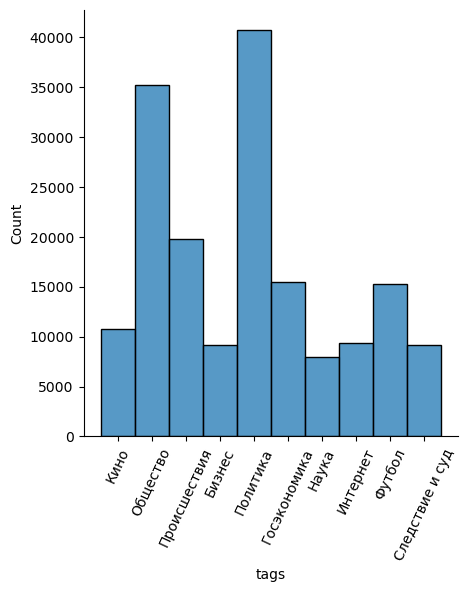

In [11]:
# Осмотр tartet-переменной.
g = sns.displot(data["tags"])
plt.xticks(rotation=65)
plt.show()

Теперь посмотрим, как выглядит новость.

In [12]:
data["text"].iloc[1]

'Власти одного из районов столицы Южной Кореи запустили программу организации знакомств одиноких мужчин и женщин. Об этом 13 ноября сообщает AFP. В районе Сеула Гангнаме фиксируется очень высокий уровень благосостояния граждан, но очень низкий уровень рождаемости. Власти предоставляют молодым родителям крупные денежные бонусы: миллион вон (854 доллара) за рождение второго ребенка, пять миллионов за третьего ребенка и десять миллионов за четвертого. Однако ситуация не улучшается. Чиновники пришли к выводу, что многие местные жители не обзаводятся потомством просто потому, что не имеют пары. Они слишком заняты работой, чтобы устраивать личную жизнь. По данным The Korea Times, в Гангнаме незамужними остаются 65 процентов женщин 25-34 лет (при среднем показателе по городу 51 процент). В связи с этим районные власти решили взять сватовство на себя. Теперь в Гангнаме трижды в год по субботам будет устраиваться встреча 30 мужчин и 30 женщин, желающих найти спутника жизни. Первая такая встреча

Так как это датасет официальных новостей, в нём не очень много мусора. Тем не менее, есть смысл выкинуть цифры и спец символы из текстов, для этого напишем функцию.

In [13]:
def preprocess_text(text):
    text = text.lower()

    text = re.sub(r"\d+", "", text)  # убрать цифры
    text = re.sub(r"[^\w\s]", "", text)  # убрать специальные символы

    tokens = nltk.word_tokenize(text, language="russian")

    return tokens


def remove_stopwords(tokens):
    stop_words = set(stopwords.words("russian"))
    clean_tokens = [token for token in tokens if token not in stop_words]

    return " ".join(tokens)

In [14]:
data["prepared_texts"] = data["text"].apply(preprocess_text)

In [15]:
data["prepared_texts"] = data["prepared_texts"].apply(remove_stopwords)

Посмотрим, что у нас получилось:

In [16]:
data["prepared_texts"].iloc[1]

'власти одного из районов столицы южной кореи запустили программу организации знакомств одиноких мужчин и женщин об этом ноября сообщает afp в районе сеула гангнаме фиксируется очень высокий уровень благосостояния граждан но очень низкий уровень рождаемости власти предоставляют молодым родителям крупные денежные бонусы миллион вон доллара за рождение второго ребенка пять миллионов за третьего ребенка и десять миллионов за четвертого однако ситуация не улучшается чиновники пришли к выводу что многие местные жители не обзаводятся потомством просто потому что не имеют пары они слишком заняты работой чтобы устраивать личную жизнь по данным the korea times в гангнаме незамужними остаются процентов женщин лет при среднем показателе по городу процент в связи с этим районные власти решили взять сватовство на себя теперь в гангнаме трижды в год по субботам будет устраиваться встреча мужчин и женщин желающих найти спутника жизни первая такая встреча пройдет ноября года на мероприятие приглашены 

Теперь займемся созданием TfidfVectorizer и применением его к данным. Обучим его на train, применем к train и test7.

In [17]:
tfidfvectorizer = TfidfVectorizer(analyzer="word",
                                  lowercase=False)

Проверим на первых 100 строках

In [18]:
tfidf_test = tfidfvectorizer.fit_transform(data["prepared_texts"].iloc[:100])

In [19]:
tfidf_test

<100x7744 sparse matrix of type '<class 'numpy.float64'>'
	with 14642 stored elements in Compressed Sparse Row format>

Всё хорошо. Теперь давайте перепишем наш код следующим образом:
  - Сделаем единую функцию для деления на train/test и  препроцессинга
  - изменим return функции preprocess_text для того, чтобы использовать его прямо внутри TfidfVectorizer

In [20]:
def preprocess_text(text:str) -> str:
    text = text.lower()

    text = re.sub(r"\d+", "", text)  # убрать цифры
    text = re.sub(r"[^\w\s]", "", text)  # убрать специальные символы

    tokens = nltk.word_tokenize(text, language="russian")

    return " ".join(tokens)

In [21]:
def preprocess_data(data: pd.DataFrame) -> Tuple[np.array, np.array, pd.Series, pd.Series]:
    
    # Разделить на train и test
    train, test = train_test_split(data, test_size=0.2, stratify=data["tags"])

    # Подготовить TFidf
    tfidfvectorizer = TfidfVectorizer(analyzer="word",
                                      lowercase=False,
                                      stop_words=list(
                                          stopwords.words("russian")),
                                      preprocessor=preprocess_text)

    # Обучить TFidf на train, применить к train и test
    X_train = tfidfvectorizer.fit_transform(train["text"])
    X_test = tfidfvectorizer.transform(test["text"])

    y_train = train["tags"]
    y_test = test["tags"]

    return X_train, X_test, y_train, y_test

Получем датасеты для обучения

In [22]:
X_train, X_test, y_train, y_test = preprocess_data(data)

Обучаем логистическую регрессию

In [23]:
model_lr = LogisticRegression(max_iter=1000)

In [24]:
model_lr.fit(X_train, y_train)

LogisticRegression(max_iter=1000)

In [26]:
y_pred_lr = model_lr.predict(X_test)

In [27]:
print(classification_report(y_test, y_pred_lr))

                 precision    recall  f1-score   support

         Бизнес       0.81      0.76      0.78      1829
   Госэкономика       0.86      0.84      0.85      3095
       Интернет       0.87      0.79      0.83      1864
           Кино       0.96      0.95      0.95      2144
          Наука       0.98      0.92      0.95      1586
       Общество       0.70      0.74      0.72      7041
       Политика       0.85      0.87      0.86      8143
   Происшествия       0.76      0.77      0.77      3965
Следствие и суд       0.82      0.76      0.79      1827
         Футбол       0.98      0.97      0.98      3048

       accuracy                           0.83     34542
      macro avg       0.86      0.84      0.85     34542
   weighted avg       0.83      0.83      0.83     34542



Обучаем наивный Байес

In [28]:
model_nb = MultinomialNB()

In [29]:
model_nb.fit(X_train, y_train)

MultinomialNB()

In [30]:
y_pred_nb = model_nb.predict(X_test)

In [31]:
print(classification_report(y_test, y_pred_nb))

                 precision    recall  f1-score   support

         Бизнес       0.93      0.24      0.38      1829
   Госэкономика       0.78      0.65      0.71      3095
       Интернет       0.97      0.21      0.35      1864
           Кино       0.98      0.73      0.84      2144
          Наука       1.00      0.62      0.77      1586
       Общество       0.46      0.74      0.57      7041
       Политика       0.64      0.93      0.76      8143
   Происшествия       0.83      0.51      0.63      3965
Следствие и суд       0.99      0.09      0.16      1827
         Футбол       0.99      0.89      0.94      3048

       accuracy                           0.67     34542
      macro avg       0.86      0.56      0.61     34542
   weighted avg       0.76      0.67      0.65     34542



Ура! Мы великолепны! Можем идти переписывать этот код в AirFlow пайплайн.

# Основы AirFlow <a id="airflow"></a>

Написание AirFlow пайплайна будет состоять из двух частей:
  - разбор основных конструкций AirFlow в ноутбуке
  - перенесение кода в полноценный пайплайна в py-файле

## Основа DAG

### Импорты

In [ ]:
# S3Hook для коннекта к S3. Требует установки apache-airflow-providers-amazon!
from airflow.providers.amazon.aws.hooks.s3 import S3Hook
# S3Hook для коннекта к базе Postgres. Требует установки apache-airflow-providers-postgres!
from airflow.providers.postgres.hooks.postgres import PostgresHook
# Основа DAG'a.
from airflow.models import DAG
# Оператор для исполнения python-кода.
from airflow.operators.python_operator import PythonOperator
# Date утилита от airflow.
from airflow.utils.dates import days_ago

### Параметры, описывающие работу DAG’а

In [ ]:
DEFAULT_ARGS = {
    "owner": "Name Surname",  # Ваше имя и фамилия
    "email": "example@gmail.com",  # email в случае настройки алертов на почту
    "email_on_failure": True,  # Алерт по неудачам
    "email_on_retry": False,  # Алерт по попыткам
    "retry": 3,  # Количество попыток
    "retry_delay": timedelta(minutes=1)  # Задержка между попытками
}

train_dag = DAG(
    dag_id="train_models",  # Имя DAG'a
    schedule_interval="0 1 * * *",  # Расписание запусков (ежедневно в полночь)
    start_date=days_ago(2),  # Дата запуска
    tags=["mlops"],  # Теги
    default_args=DEFAULT_ARGS)  # Параметры по умолчанию

## PythonOperator

In [34]:
datetime.now().strftime("%Y%m%d %H:%M")

'20240407 18:33'

In [ ]:
# Ниже описана функция инициализации пайплайна, некий шаг 0.
# В нем мы хотим зафиксировать таймстемп запуска пайплайна и период обучения.
# Период: с сегодня и на два года назад. Вопрос високосных годов нам не важен.
def init() -> Dict[str, Any]:
    """
    Step0: Pipeline initialisation.
    """
    info = {}
    info["start_tiemstamp"] = datetime.now().strftime("%Y%m%d %H:%M")
    info["dataset_start"] = datetime.now().strftime("%Y-%m-%d")
    info["dataset_end"] = (datetime.now() -
                           timedelta(365 * 2)).strftime("%Y-%m-%d")
    # Return нам нужен для того, чтобы передать словарь info в следующий шаг,
    # (вспомниаем слайды по XCom).
    return info

# А так мы создаем шаг на языке AirFlow.
task_init = PythonOperator(task_id="init", python_callable=init, dag=train_dag)

## XCOM

In [ ]:
def init() -> Dict[str, Any]:
    """
    Step0: Pipeline initialisation.
    """
    info = {}
    info["start_tiemstamp"] = datetime.now().strftime("%Y%m%d %H:%M")
    info["dataset_start"] = datetime.now().strftime("%Y-%m-%d")
    info["dataset_end"] = (datetime.now() -
                           timedelta(365 * 2)).strftime("%Y-%m-%d")
    # Отправили info в XCom.
    return info


def get_data_from_postgres(**kwargs) -> Dict[str, Any]:
    """
    Step1: Read data from news PG table and save to S3.
    """
    # Вытаскиваем task instance.
    ti = kwargs["ti"]
    # Вытаскиваем return от задания init.
    info = ti.xcom_pull(task_ids="init")
    
    ### SOME CODE HERE ###
    
    return info


task_get_data = PythonOperator(task_id="get_data",
                               python_callable=get_data_from_postgres,
                               dag=train_dag,
                               # Не забываем включить контекст для операторов, принимающих его.
                               provide_context=True)

## Hooks

Хуки используют созданные администратом connections.

### Postgres Hook

In [ ]:
def get_data_from_postgres(**kwargs) -> Dict[str, Any]:
    """
    Step1: Read data from news PG table and save to S3.
    """
    start = 'somedate'
    end = 'somedate'
    
    # Использовать созданный ранее PG connection
    pg_hook = PostgresHook("pg_connection")
    con = pg_hook.get_conn()

    # Прочитать данные из таблицы news
    data = pd.read_sql_query(
        f"SELECT * FROM news WHERE date BETWEEN '{start}' and '{end}'", con)
    
    ### SOME CODE HERE ###

### S3 Hook

Сохранение на S3

In [ ]:
def get_data_from_postgres(**kwargs) -> Dict[str, Any]:
    """
    Step1: Read data from news PG table and save to S3.
    """
    ### SOME CODE HERE ###
    data = ...

    # Использовать созданный ранее S3 connection
    s3_hook = S3Hook("s3_connection")

    # Сохранить файл в формате pkl на S3
    pickle_byte_obj = pickle.dumps(data)
    resource.Object(BUCKET, "bootcamp/datasets/news.pkl").put(Body=pickle_byte_obj)

Чтение с S3

In [ ]:
def prepare_data(**kwargs) -> Dict[str, Any]:
    """
    Step 2: Prepare data for training.
    """

    ### SOME CODE HERE ###

    # Использовать созданный ранее S3 connection
    s3_hook = S3Hook("s3_connection")
    
    # Прочитать файл в формате pkl с S3
    file = s3_hook.download_file(key="bootcamp/datasets/news.pkl", bucket_name=BUCKET)
    data = pd.read_pickle(file)

## Operator kwargs
Способ передачи параметров в оператор извне (но не из другого задания).

In [37]:
# Зададим словарь моделей
models = dict(
    zip(["logreg", "nb"], [
        LogisticRegression(max_iter=1000),
        MultinomialNB(),
    ]))

In [41]:
models

{'logreg': LogisticRegression(max_iter=1000), 'nb': MultinomialNB()}

In [42]:
model_name = list(models.keys())[0]
model_name

'logreg'

In [ ]:
task_example = PythonOperator(task_id=f"train_model",
                              python_callable=train_model,
                              dag=dag,
                              provide_context=True,
                              op_kwargs={"model_name": model_name})

In [ ]:
def train_model(**kwargs) -> Dict[str, Any]:
    """
    Step 3: Train logistic regression.
    """
    ti = kwargs["ti"]
    info = ti.xcom_pull(task_ids="prepare_data")
    name = kwargs["model_name"]

    print(name)

In [ ]:
task_example = PythonOperator(task_id=f"train_model",
                              python_callable=train_model,
                              dag=dag,
                              provide_context=True,
                              # Передаем logreg в качстве model_name в ti.
                              op_kwargs={"model_name": model_name})

In [ ]:
def train_model(**kwargs) -> Dict[str, Any]:
    """
    Step 3: Train logistic regression.
    """
    # Вытаскиваем полученное имя модели
    ti = kwargs["ti"]
    info = ti.xcom_pull(task_ids="prepare_data")
    name = kwargs["model_name"]

    print(name)

## Создание task instance в цикле

In [ ]:
task_train_models = [
    PythonOperator(task_id=f"train_{model_name}",
                   python_callable=train_model,
                   dag=dag,
                   provide_context=True,
                   op_kwargs={"model_name": model_name})
    for model_name in models.keys()
]

## Создание последовательности заданий в DAG

In [ ]:
task_init >> task_get_data >> task_prepare_data >> task_train_models >> task_save_results

# py-файл<a id="py"></a>

А теперь перенесем все в py-файл и запустим.